C:\Users\Alpha\AppData\Local\Temp\ipykernel_8396\93031840.py:118: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=85, p=0.2)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

Epoch 1: 100%|██████████| 15/15 [00:00<00:00, 20.60it/s, Loss=5.41, Acc=4.33%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.00      0.00      0.00        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 2: 100%|██████████| 15/15 [00:00<00:00, 22.19it/s, Loss=5.05, Acc=10.67%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.00      0.00      0.00        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 3: 100%|██████████| 15/15 [00:00<00:00, 20.51it/s, Loss=4.95, Acc=13.69%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.00      0.00      0.00        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 4: 100%|██████████| 15/15 [00:00<00:00, 21.78it/s, Loss=4.79, Acc=15.76%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.00      0.00      0.00        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 5: 100%|██████████| 15/15 [00:00<00:00, 19.94it/s, Loss=4.73, Acc=18.18%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.67      0.17      0.27        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 6: 100%|██████████| 15/15 [00:00<00:00, 20.87it/s, Loss=4.4, Acc=20.54%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.33      0.58      0.42        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 7: 100%|██████████| 15/15 [00:00<00:00, 19.13it/s, Loss=4.22, Acc=21.80%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       1.00      0.20      0.33         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.00      0.00      0.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.50      0.58      0.54        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 8: 100%|██████████| 15/15 [00:00<00:00, 20.97it/s, Loss=4.43, Acc=24.76%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.00      0.00      0.00         6
             Alvaro_Uribe       0.00      0.00      0.00         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       1.00      0.20      0.33         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.38      0.67      0.48        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 9: 100%|██████████| 15/15 [00:00<00:00, 20.27it/s, Loss=3.75, Acc=27.73%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.33      0.17      0.22         6
             Alvaro_Uribe       0.50      0.20      0.29         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.20      0.20      0.20         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.24      0.67      0.35        12
    Arnold_Schwarzenegger       0.00      0.00      0.00         6
     Atal_Bihari_Vajpay

Epoch 10: 100%|██████████| 15/15 [00:00<00:00, 19.90it/s, Loss=3.42, Acc=30.42%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.25      0.17      0.20         6
             Alvaro_Uribe       0.17      0.20      0.18         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.33      0.20      0.25         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.47      0.67      0.55        12
    Arnold_Schwarzenegger       1.00      0.17      0.29         6
     Atal_Bihari_Vajpay

Epoch 11: 100%|██████████| 15/15 [00:00<00:00, 19.57it/s, Loss=3.38, Acc=31.59%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.33      0.17      0.22         6
             Alvaro_Uribe       1.00      0.20      0.33         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.53      0.67      0.59        12
    Arnold_Schwarzenegger       0.25      0.17      0.20         6
     Atal_Bihari_Vajpay

Epoch 12: 100%|██████████| 15/15 [00:00<00:00, 20.59it/s, Loss=3.44, Acc=36.05%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.00      0.00      0.00         3
             Adrien_Brody       0.00      0.00      0.00         2
         Alejandro_Toledo       0.40      0.67      0.50         6
             Alvaro_Uribe       0.25      0.20      0.22         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.67      0.83      0.74        12
    Arnold_Schwarzenegger       0.20      0.17      0.18         6
     Atal_Bihari_Vajpay

Epoch 13: 100%|██████████| 15/15 [00:00<00:00, 20.99it/s, Loss=4.28, Acc=42.01%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.44      0.67      0.53         6
             Alvaro_Uribe       0.50      0.40      0.44         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.42      1.00      0.59         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       0.00      0.00      0.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.56      0.83      0.67        12
    Arnold_Schwarzenegger       0.50      0.33      0.40         6
     Atal_Bihari_Vajpay

Epoch 14: 100%|██████████| 15/15 [00:00<00:00, 19.71it/s, Loss=3.21, Acc=42.39%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       1.00      0.50      0.67         2
         Alejandro_Toledo       0.50      0.67      0.57         6
             Alvaro_Uribe       0.40      0.40      0.40         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.44      0.80      0.57         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      0.50      0.67         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.00      0.00      0.00         2
             Ariel_Sharon       0.56      0.83      0.67        12
    Arnold_Schwarzenegger       0.60      0.50      0.55         6
     Atal_Bihari_Vajpay

Epoch 15: 100%|██████████| 15/15 [00:00<00:00, 20.56it/s, Loss=2.82, Acc=45.99%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.67      0.67      0.67         6
             Alvaro_Uribe       0.43      0.60      0.50         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.40      0.80      0.53         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.00      0.00      0.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.77      0.83      0.80        12
    Arnold_Schwarzenegger       0.67      0.67      0.67         6
     Atal_Bihari_Vajpay

Epoch 16: 100%|██████████| 15/15 [00:00<00:00, 21.50it/s, Loss=2.88, Acc=56.24%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.67      0.67      0.67         6
             Alvaro_Uribe       0.67      0.40      0.50         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.44      0.80      0.57         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.71      0.83      0.77         6
     Atal_Bihari_Vajpay

Epoch 17: 100%|██████████| 15/15 [00:00<00:00, 20.25it/s, Loss=2.3, Acc=61.96%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       0.50      0.40      0.44         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.36      0.80      0.50         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       0.62      0.83      0.71         6
     Atal_Bihari_Vajpay

Epoch 18: 100%|██████████| 15/15 [00:00<00:00, 20.12it/s, Loss=2.18, Acc=61.01%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.36      0.80      0.50         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       0.56      0.83      0.67         6
     Atal_Bihari_Vajpay

Epoch 19: 100%|██████████| 15/15 [00:00<00:00, 20.84it/s, Loss=1.87, Acc=61.50%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.44      0.80      0.57         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.38      1.00      0.56         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       0.57      0.67      0.62         6
     Atal_Bihari_Vajpay

Epoch 20: 100%|██████████| 15/15 [00:00<00:00, 20.00it/s, Loss=1.81, Acc=72.46%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 21: 100%|██████████| 15/15 [00:00<00:00, 19.64it/s, Loss=1.8, Acc=79.70%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 22: 100%|██████████| 15/15 [00:00<00:00, 20.01it/s, Loss=1.54, Acc=79.89%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 23: 100%|██████████| 15/15 [00:00<00:00, 20.24it/s, Loss=1.69, Acc=76.14%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.77      0.83      0.80        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 24: 100%|██████████| 15/15 [00:00<00:00, 21.14it/s, Loss=1.61, Acc=86.75%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.61      0.92      0.73        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 25: 100%|██████████| 15/15 [00:00<00:00, 20.90it/s, Loss=3.05, Acc=78.78%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.50      0.40      0.44         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.45      1.00      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 26: 100%|██████████| 15/15 [00:00<00:00, 22.36it/s, Loss=1.36, Acc=81.55%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.40      1.00      0.57         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.40      0.80      0.53         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 27: 100%|██████████| 15/15 [00:00<00:00, 19.68it/s, Loss=1.4, Acc=88.73%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.42      1.00      0.59         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.59      0.83      0.69        12
    Arnold_Schwarzenegger       0.62      0.83      0.71         6
     Atal_Bihari_Vajpay

Epoch 28: 100%|██████████| 15/15 [00:00<00:00, 22.70it/s, Loss=1.29, Acc=86.61%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 29: 100%|██████████| 15/15 [00:00<00:00, 21.81it/s, Loss=1.24, Acc=91.40%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.67      0.40      0.50         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.65      0.92      0.76        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 30: 100%|██████████| 15/15 [00:00<00:00, 20.18it/s, Loss=1.21, Acc=89.25%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.65      0.92      0.76        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 31: 100%|██████████| 15/15 [00:00<00:00, 19.42it/s, Loss=1.35, Acc=92.35%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.62      0.83      0.71         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.75      1.00      0.86         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 32: 100%|██████████| 15/15 [00:00<00:00, 20.06it/s, Loss=1.22, Acc=90.86%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.50      0.80      0.62         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.50      0.67         6
     Atal_Bihari_Vajpay

Epoch 33: 100%|██████████| 15/15 [00:00<00:00, 21.68it/s, Loss=1.23, Acc=93.66%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.62      0.83      0.71         6
             Alvaro_Uribe       0.67      0.80      0.73         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.86      1.00      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 34: 100%|██████████| 15/15 [00:00<00:00, 20.00it/s, Loss=1.12, Acc=84.79%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 35: 100%|██████████| 15/15 [00:00<00:00, 21.72it/s, Loss=1.16, Acc=97.14%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.56      0.83      0.67         6
             Alvaro_Uribe       0.44      0.80      0.57         5
          Amelie_Mauresmo       0.33      0.33      0.33         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 36: 100%|██████████| 15/15 [00:00<00:00, 21.53it/s, Loss=1.09, Acc=92.14%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.38      0.60      0.46         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       1.00      0.50      0.67         6
     Atal_Bihari_Vajpay

Epoch 37: 100%|██████████| 15/15 [00:00<00:00, 23.46it/s, Loss=1.1, Acc=93.66%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.50      0.33      0.40         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      0.50      0.67         6
     Atal_Bihari_Vajpay

Epoch 38: 100%|██████████| 15/15 [00:00<00:00, 21.50it/s, Loss=1.23, Acc=97.77%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.62      0.83      0.71         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.67      0.67      0.67         6
     Atal_Bihari_Vajpay

Epoch 39: 100%|██████████| 15/15 [00:00<00:00, 22.07it/s, Loss=1.1, Acc=89.36%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 40: 100%|██████████| 15/15 [00:00<00:00, 21.44it/s, Loss=1.1, Acc=98.39%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      1.00      0.67         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 41: 100%|██████████| 15/15 [00:00<00:00, 22.61it/s, Loss=1.11, Acc=92.90%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 42: 100%|██████████| 15/15 [00:00<00:00, 21.79it/s, Loss=1.02, Acc=92.71%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.57      0.80      0.67         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 43: 100%|██████████| 15/15 [00:00<00:00, 21.81it/s, Loss=1.06, Acc=95.81%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 44: 100%|██████████| 15/15 [00:00<00:00, 21.62it/s, Loss=2.48, Acc=92.49%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.57      0.80      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 45: 100%|██████████| 15/15 [00:00<00:00, 22.72it/s, Loss=1.09, Acc=98.86%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.67      0.40      0.50         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 46: 100%|██████████| 15/15 [00:00<00:00, 23.76it/s, Loss=2.22, Acc=90.07%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.42      1.00      0.59         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.50      0.67         6
     Atal_Bihari_Vajpay

Epoch 47: 100%|██████████| 15/15 [00:00<00:00, 22.85it/s, Loss=1.03, Acc=95.56%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.50      1.00      0.67         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.80      0.80      0.80         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       0.75      0.50      0.60         6
     Atal_Bihari_Vajpay

Epoch 48: 100%|██████████| 15/15 [00:00<00:00, 21.97it/s, Loss=2.16, Acc=95.92%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.71      0.83      0.77        12
    Arnold_Schwarzenegger       1.00      0.50      0.67         6
     Atal_Bihari_Vajpay

Epoch 49: 100%|██████████| 15/15 [00:00<00:00, 22.00it/s, Loss=2.14, Acc=93.69%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.50      0.83      0.62         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.20      0.50      0.29         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.83      0.91        12
    Arnold_Schwarzenegger       1.00      0.50      0.67         6
     Atal_Bihari_Vajpay

Epoch 50: 100%|██████████| 15/15 [00:00<00:00, 21.64it/s, Loss=0.961, Acc=96.84%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.67      0.67      0.67         6
     Atal_Bihari_Vajpay

Epoch 51: 100%|██████████| 15/15 [00:00<00:00, 21.62it/s, Loss=1.02, Acc=97.09%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.67      0.40      0.50         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 52: 100%|██████████| 15/15 [00:00<00:00, 22.34it/s, Loss=1.05, Acc=95.05%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.50      0.40      0.44         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 53: 100%|██████████| 15/15 [00:00<00:00, 21.95it/s, Loss=2.23, Acc=94.10%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.20      0.50      0.29         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      1.00      1.00        12
    Arnold_Schwarzenegger       0.67      0.67      0.67         6
     Atal_Bihari_Vajpay

Epoch 54: 100%|██████████| 15/15 [00:00<00:00, 20.68it/s, Loss=1.03, Acc=96.82%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.33      0.67      0.44         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      1.00      1.00        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 55: 100%|██████████| 15/15 [00:00<00:00, 22.03it/s, Loss=1.01, Acc=90.88%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 56: 100%|██████████| 15/15 [00:00<00:00, 21.34it/s, Loss=0.983, Acc=91.59%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.62      0.83      0.71         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 57: 100%|██████████| 15/15 [00:00<00:00, 21.05it/s, Loss=1.02, Acc=99.46%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.62      0.83      0.71         6
             Alvaro_Uribe       0.50      0.40      0.44         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.38      1.00      0.56         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 58: 100%|██████████| 15/15 [00:00<00:00, 18.70it/s, Loss=0.973, Acc=96.84%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.31      1.00      0.48         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 59: 100%|██████████| 15/15 [00:00<00:00, 19.23it/s, Loss=1.97, Acc=92.60%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.50      0.83      0.62         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 60: 100%|██████████| 15/15 [00:00<00:00, 20.08it/s, Loss=1.9, Acc=95.05%]  



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.42      1.00      0.59         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.71      1.00      0.83        12
    Arnold_Schwarzenegger       0.67      0.67      0.67         6
     Atal_Bihari_Vajpay

Epoch 61: 100%|██████████| 15/15 [00:00<00:00, 20.21it/s, Loss=0.959, Acc=99.65%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.62      0.83      0.71         6
             Alvaro_Uribe       0.43      0.60      0.50         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 62: 100%|██████████| 15/15 [00:00<00:00, 21.28it/s, Loss=1.01, Acc=97.85%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.67      0.67      0.67         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.45      1.00      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.86      1.00      0.92        12
    Arnold_Schwarzenegger       1.00      0.50      0.67         6
     Atal_Bihari_Vajpay

Epoch 63: 100%|██████████| 15/15 [00:00<00:00, 21.41it/s, Loss=0.924, Acc=93.99%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       1.00      0.50      0.67         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.63      1.00      0.77        12
    Arnold_Schwarzenegger       0.75      0.50      0.60         6
     Atal_Bihari_Vajpay

Epoch 64: 100%|██████████| 15/15 [00:00<00:00, 21.10it/s, Loss=1.81, Acc=95.95%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.90      0.75      0.82        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 65: 100%|██████████| 15/15 [00:00<00:00, 19.20it/s, Loss=0.969, Acc=96.00%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.65      0.92      0.76        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 66: 100%|██████████| 15/15 [00:00<00:00, 22.20it/s, Loss=0.931, Acc=93.44%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.67      0.67      0.67         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.17      0.50      0.25         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 67: 100%|██████████| 15/15 [00:00<00:00, 20.02it/s, Loss=0.911, Acc=96.63%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       0.75      0.50      0.60         6
     Atal_Bihari_Vajpay

Epoch 68: 100%|██████████| 15/15 [00:00<00:00, 22.00it/s, Loss=0.912, Acc=97.88%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.00      0.00      0.00         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 69: 100%|██████████| 15/15 [00:00<00:00, 20.90it/s, Loss=1.85, Acc=97.63%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.20      0.50      0.29         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.75      1.00      0.86        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 70: 100%|██████████| 15/15 [00:00<00:00, 21.08it/s, Loss=0.902, Acc=97.71%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.20      0.50      0.29         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 71: 100%|██████████| 15/15 [00:00<00:00, 22.03it/s, Loss=0.908, Acc=97.03%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       1.00      1.00      1.00         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.80      1.00      0.89        12
    Arnold_Schwarzenegger       0.50      0.67      0.57         6
     Atal_Bihari_Vajpay

Epoch 72: 100%|██████████| 15/15 [00:00<00:00, 21.31it/s, Loss=0.919, Acc=93.22%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.83      0.83      0.83        12
    Arnold_Schwarzenegger       1.00      0.83      0.91         6
     Atal_Bihari_Vajpay

Epoch 73: 100%|██████████| 15/15 [00:00<00:00, 21.81it/s, Loss=0.912, Acc=99.89%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.67      0.40      0.50         5
          Amelie_Mauresmo       0.33      0.33      0.33         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 74: 100%|██████████| 15/15 [00:00<00:00, 21.59it/s, Loss=1.52, Acc=93.96%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.50      0.67         6
     Atal_Bihari_Vajpay

Epoch 75: 100%|██████████| 15/15 [00:00<00:00, 20.64it/s, Loss=0.922, Acc=97.36%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.67      1.00      0.80         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 76: 100%|██████████| 15/15 [00:00<00:00, 21.68it/s, Loss=0.903, Acc=98.48%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 77: 100%|██████████| 15/15 [00:00<00:00, 22.13it/s, Loss=0.895, Acc=98.50%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 78: 100%|██████████| 15/15 [00:00<00:00, 20.93it/s, Loss=0.882, Acc=97.36%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 79: 100%|██████████| 15/15 [00:00<00:00, 22.72it/s, Loss=0.897, Acc=98.75%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.43      0.60      0.50         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.86      1.00      0.92        12
    Arnold_Schwarzenegger       0.67      0.67      0.67         6
     Atal_Bihari_Vajpay

Epoch 80: 100%|██████████| 15/15 [00:00<00:00, 21.25it/s, Loss=0.904, Acc=98.59%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 81: 100%|██████████| 15/15 [00:00<00:00, 19.29it/s, Loss=0.873, Acc=96.27%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.67      0.40      0.50         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.69      0.92      0.79        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 82: 100%|██████████| 15/15 [00:00<00:00, 21.25it/s, Loss=0.89, Acc=97.74%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 83: 100%|██████████| 15/15 [00:00<00:00, 21.38it/s, Loss=0.881, Acc=97.69%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 84: 100%|██████████| 15/15 [00:00<00:00, 19.76it/s, Loss=0.887, Acc=97.74%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.67      1.00      0.80         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 85: 100%|██████████| 15/15 [00:00<00:00, 20.21it/s, Loss=0.89, Acc=98.72%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 86: 100%|██████████| 15/15 [00:00<00:00, 22.13it/s, Loss=1.81, Acc=99.29%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 87: 100%|██████████| 15/15 [00:00<00:00, 19.53it/s, Loss=0.873, Acc=97.93%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.33      0.33      0.33         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 88: 100%|██████████| 15/15 [00:00<00:00, 19.20it/s, Loss=0.88, Acc=97.80%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.33      0.33      0.33         3
             Andre_Agassi       0.38      1.00      0.56         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      1.00      1.00        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 89: 100%|██████████| 15/15 [00:00<00:00, 22.18it/s, Loss=0.903, Acc=97.58%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.45      1.00      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       1.00      1.00      1.00        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 90: 100%|██████████| 15/15 [00:00<00:00, 22.99it/s, Loss=0.888, Acc=100.00%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 91: 100%|██████████| 15/15 [00:00<00:00, 21.35it/s, Loss=0.873, Acc=99.02%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.36      1.00      0.53         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      1.00      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 92: 100%|██████████| 15/15 [00:00<00:00, 22.00it/s, Loss=0.864, Acc=100.00%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      1.00      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 93: 100%|██████████| 15/15 [00:00<00:00, 22.60it/s, Loss=0.87, Acc=98.88%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      1.00      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 94: 100%|██████████| 15/15 [00:00<00:00, 20.71it/s, Loss=1.49, Acc=96.79%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 95: 100%|██████████| 15/15 [00:00<00:00, 20.21it/s, Loss=1.44, Acc=93.71%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.92      1.00      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 96: 100%|██████████| 15/15 [00:00<00:00, 20.64it/s, Loss=0.866, Acc=98.20%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.92      1.00      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 97: 100%|██████████| 15/15 [00:00<00:00, 21.97it/s, Loss=0.884, Acc=97.36%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.38      0.83      0.53         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.86      1.00      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 98: 100%|██████████| 15/15 [00:00<00:00, 22.10it/s, Loss=0.89, Acc=97.99%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      0.67      0.80         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 99: 100%|██████████| 15/15 [00:00<00:00, 21.19it/s, Loss=0.874, Acc=98.78%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 100: 100%|██████████| 15/15 [00:00<00:00, 21.56it/s, Loss=1.31, Acc=98.64%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.45      1.00      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.80      1.00      0.89        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 101: 100%|██████████| 15/15 [00:00<00:00, 21.22it/s, Loss=0.873, Acc=99.24%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.25      0.33      0.29         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 102: 100%|██████████| 15/15 [00:00<00:00, 21.75it/s, Loss=0.874, Acc=99.10%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.56      0.83      0.67         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.33      0.33      0.33         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 103: 100%|██████████| 15/15 [00:00<00:00, 22.29it/s, Loss=0.87, Acc=98.23%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      1.00      1.00        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 104: 100%|██████████| 15/15 [00:00<00:00, 21.94it/s, Loss=0.864, Acc=99.13%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.67      0.40      0.50         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.92      1.00      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 105: 100%|██████████| 15/15 [00:00<00:00, 20.21it/s, Loss=1.37, Acc=99.65%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       0.33      0.33      0.33         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       1.00      1.00      1.00        12
    Arnold_Schwarzenegger       0.67      0.67      0.67         6
     Atal_Bihari_Vajpay

Epoch 106: 100%|██████████| 15/15 [00:00<00:00, 22.36it/s, Loss=0.862, Acc=98.86%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.92      1.00      0.96        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 107: 100%|██████████| 15/15 [00:00<00:00, 20.59it/s, Loss=0.862, Acc=96.08%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.62      0.83      0.71         6
             Alvaro_Uribe       0.67      0.40      0.50         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.80      1.00      0.89        12
    Arnold_Schwarzenegger       0.67      0.67      0.67         6
     Atal_Bihari_Vajpay

Epoch 108: 100%|██████████| 15/15 [00:00<00:00, 21.81it/s, Loss=0.869, Acc=98.83%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 109: 100%|██████████| 15/15 [00:00<00:00, 21.21it/s, Loss=1.41, Acc=98.97%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.67      0.67      0.67         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      1.00      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 110: 100%|██████████| 15/15 [00:00<00:00, 22.96it/s, Loss=0.86, Acc=99.05%]  



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 111: 100%|██████████| 15/15 [00:00<00:00, 21.35it/s, Loss=0.859, Acc=98.61%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 112: 100%|██████████| 15/15 [00:00<00:00, 20.71it/s, Loss=0.864, Acc=98.99%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 113: 100%|██████████| 15/15 [00:00<00:00, 20.56it/s, Loss=0.859, Acc=98.39%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.50      0.67         6
     Atal_Bihari_Vajpay

Epoch 114: 100%|██████████| 15/15 [00:00<00:00, 22.08it/s, Loss=0.858, Acc=99.46%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.86      1.00      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 115: 100%|██████████| 15/15 [00:00<00:00, 21.65it/s, Loss=0.858, Acc=99.37%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.92      1.00      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 116: 100%|██████████| 15/15 [00:00<00:00, 23.01it/s, Loss=0.862, Acc=99.97%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.67      1.00      0.80         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 117: 100%|██████████| 15/15 [00:00<00:00, 18.52it/s, Loss=0.859, Acc=95.54%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.91      0.83      0.87        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 118: 100%|██████████| 15/15 [00:00<00:00, 19.30it/s, Loss=0.857, Acc=99.16%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.67      1.00      0.80         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 119: 100%|██████████| 15/15 [00:00<00:00, 21.08it/s, Loss=0.862, Acc=98.12%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      1.00      0.67         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 120: 100%|██████████| 15/15 [00:00<00:00, 19.86it/s, Loss=0.856, Acc=99.07%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.80      0.67      0.73         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.67      1.00      0.80         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 121: 100%|██████████| 15/15 [00:00<00:00, 21.75it/s, Loss=0.866, Acc=98.50%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       0.67      1.00      0.80         2
             Ariel_Sharon       0.85      0.92      0.88        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 122: 100%|██████████| 15/15 [00:00<00:00, 21.02it/s, Loss=0.856, Acc=97.88%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.60      1.00      0.75         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.67      1.00      0.80         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 123: 100%|██████████| 15/15 [00:00<00:00, 20.86it/s, Loss=0.86, Acc=99.27%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.67      1.00      0.80         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 124: 100%|██████████| 15/15 [00:00<00:00, 21.14it/s, Loss=0.854, Acc=99.48%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 125: 100%|██████████| 15/15 [00:00<00:00, 21.35it/s, Loss=0.857, Acc=99.37%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 126: 100%|██████████| 15/15 [00:00<00:00, 18.84it/s, Loss=0.852, Acc=97.63%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 127: 100%|██████████| 15/15 [00:00<00:00, 20.20it/s, Loss=0.859, Acc=99.97%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.33      0.50         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.50      0.50      0.50         2
            Ari_Fleischer       0.67      1.00      0.80         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 128: 100%|██████████| 15/15 [00:00<00:00, 21.37it/s, Loss=1.25, Acc=99.07%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 129: 100%|██████████| 15/15 [00:00<00:00, 20.47it/s, Loss=0.853, Acc=98.48%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       1.00      0.92      0.96        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 130: 100%|██████████| 15/15 [00:00<00:00, 20.90it/s, Loss=0.858, Acc=98.72%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.56      1.00      0.71         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 131: 100%|██████████| 15/15 [00:00<00:00, 20.34it/s, Loss=1.28, Acc=98.67%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.75      0.60      0.67         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 132: 100%|██████████| 15/15 [00:00<00:00, 18.36it/s, Loss=0.857, Acc=97.61%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 133: 100%|██████████| 15/15 [00:00<00:00, 19.64it/s, Loss=0.852, Acc=99.97%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.50      0.80      0.62         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 134: 100%|██████████| 15/15 [00:00<00:00, 21.38it/s, Loss=0.853, Acc=98.10%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.71      0.83      0.77         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.67      0.80      0.73         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 135: 100%|██████████| 15/15 [00:00<00:00, 21.31it/s, Loss=0.85, Acc=98.59%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.62      0.83      0.71         6
             Alvaro_Uribe       0.50      0.60      0.55         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.71      1.00      0.83         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      1.00      1.00         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 136: 100%|██████████| 15/15 [00:00<00:00, 20.59it/s, Loss=0.851, Acc=98.53%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.62      1.00      0.77         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.79      0.92      0.85        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 137: 100%|██████████| 15/15 [00:00<00:00, 21.65it/s, Loss=0.853, Acc=99.35%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       0.60      0.60      0.60         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 138: 100%|██████████| 15/15 [00:00<00:00, 20.59it/s, Loss=0.854, Acc=98.97%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       0.75      1.00      0.86         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       0.80      0.67      0.73         6
     Atal_Bihari_Vajpay

Epoch 139: 100%|██████████| 15/15 [00:00<00:00, 20.70it/s, Loss=0.85, Acc=98.26%] 



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       0.67      1.00      0.80         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.80      0.80      0.80         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.25      0.50      0.33         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 140: 100%|██████████| 15/15 [00:00<00:00, 19.83it/s, Loss=0.853, Acc=98.97%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.83      0.91         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      0.67      0.80         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       0.50      0.50      0.50         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

Epoch 141: 100%|██████████| 15/15 [00:00<00:00, 22.85it/s, Loss=0.855, Acc=98.64%]



Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       0.83      0.83      0.83         6
             Alvaro_Uribe       1.00      0.40      0.57         5
          Amelie_Mauresmo       1.00      0.33      0.50         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       1.00      1.00      1.00         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.00      0.00      0.00         2
            Ari_Fleischer       1.00      0.50      0.67         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80         6
     Atal_Bihari_Vajpay

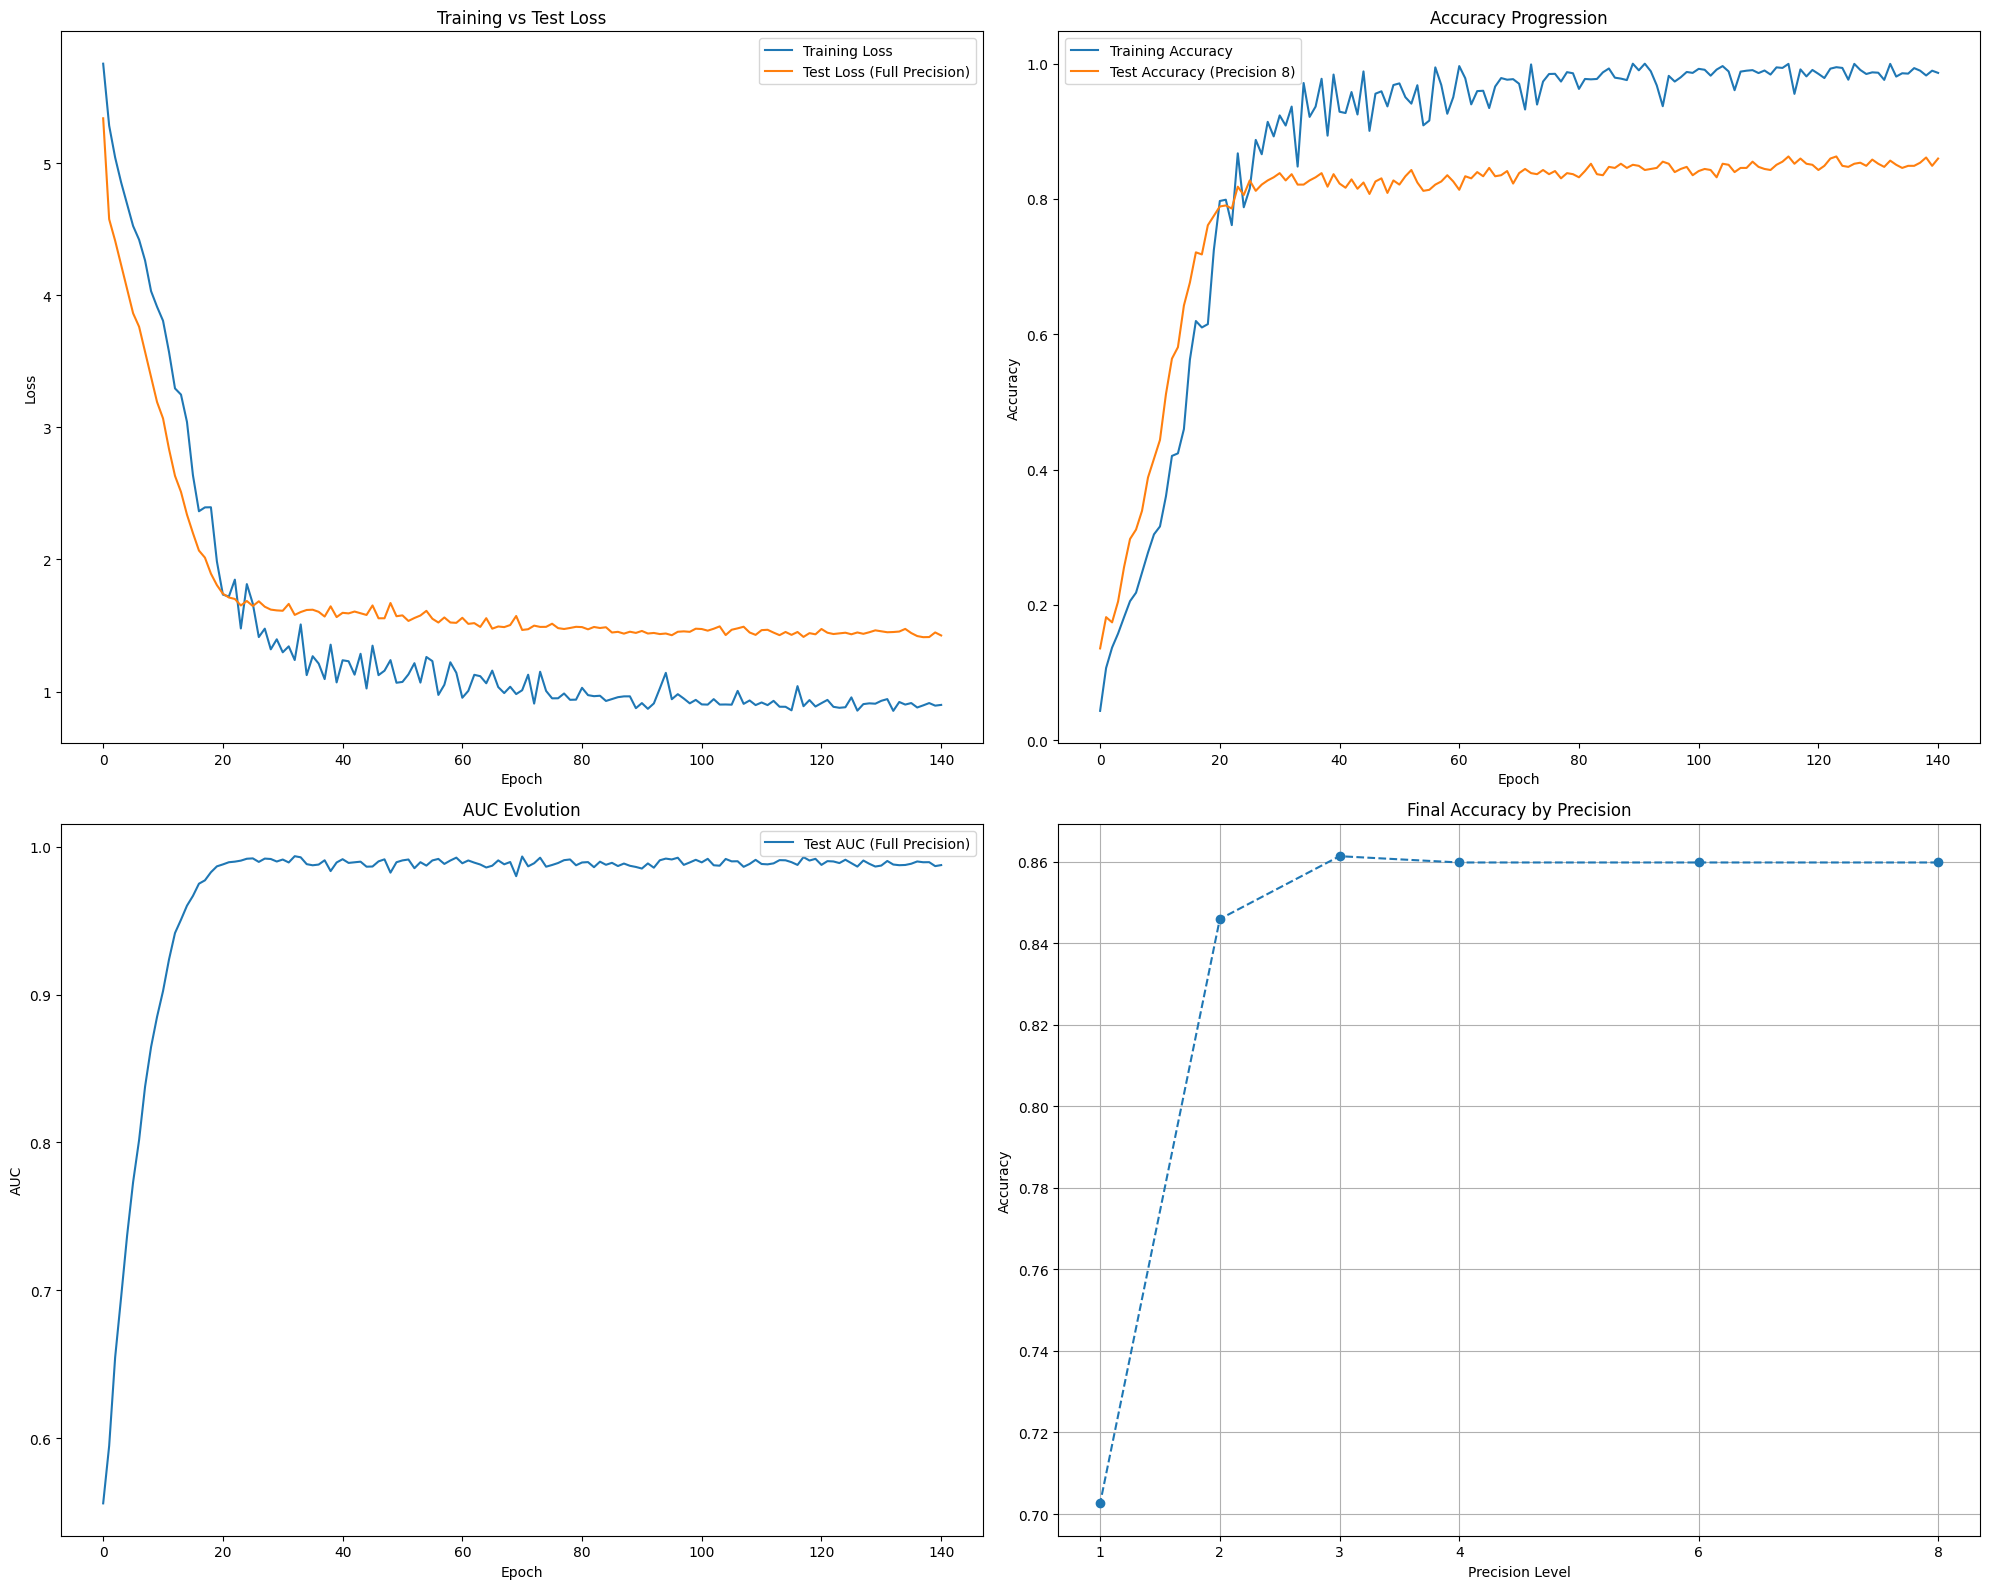


Final Evaluation Results:

Classification Report (Precision 8):
                           precision    recall  f1-score   support

             Abdullah_Gul       1.00      1.00      1.00         3
             Adrien_Brody       1.00      1.00      1.00         2
         Alejandro_Toledo       1.00      0.67      0.80         6
             Alvaro_Uribe       1.00      0.60      0.75         5
          Amelie_Mauresmo       0.50      0.33      0.40         3
             Andre_Agassi       0.83      1.00      0.91         5
             Andy_Roddick       0.00      0.00      0.00         2
           Angelina_Jolie       0.67      0.67      0.67         3
              Ann_Veneman       1.00      1.00      1.00         2
          Anna_Kournikova       0.33      0.50      0.40         2
            Ari_Fleischer       0.67      1.00      0.80         2
             Ariel_Sharon       0.92      0.92      0.92        12
    Arnold_Schwarzenegger       1.00      0.67      0.80       

In [13]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tqdm import tqdm
import insightface
from insightface.app import FaceAnalysis
import albumentations as A
from torch.cuda.amp import autocast, GradScaler

# ======================
# Enhanced Configuration
# ======================
class Config:
    # Dataset parameters
    dataset_path = 'dataset/lfw-deepfunneled/lfw-deepfunneled'
    min_samples_per_class = 10
    test_size = 0.15
    random_state = 42
    
    # Model parameters
    embedding_dim = 512
    transformer_dim = 1024
    num_heads = 8
    num_layers = 4
    dropout_rate = 0.3
    
    # Training parameters
    batch_size = 256
    epochs = 200
    learning_rate = 3e-4
    weight_decay = 1e-4
    patience = 25
    label_smoothing = 0.1
    grad_clip = 1.0
    
    # Precision parameters
    precision_levels = [8, 6, 4, 3, 2, 1]
    noise_std = 0.2
    
    # Augmentation
    augment_prob = 0.8
    
    # System
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_workers = 0

# ======================
# Transformer-based Model
# ======================
class BiometricTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=1680):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=Config.num_heads,
            dim_feedforward=Config.transformer_dim,
            dropout=Config.dropout_rate,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, Config.num_layers)
        
        self.feature_enhancer = nn.Sequential(
            nn.Linear(input_dim, Config.transformer_dim),
            nn.GELU(),
            nn.LayerNorm(Config.transformer_dim),
            nn.Dropout(Config.dropout_rate/2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(Config.transformer_dim, Config.transformer_dim//2),
            nn.GELU(),
            nn.LayerNorm(Config.transformer_dim//2),
            nn.Dropout(Config.dropout_rate),
            nn.Linear(Config.transformer_dim//2, num_classes)
        )
        
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        x = self.feature_enhancer(x)
        return self.classifier(x)

# ======================
# Enhanced Data Pipeline
# ======================
class BiometricDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.from_numpy(np.array(embeddings)).float()
        self.labels = torch.from_numpy(np.array(labels)).long()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.3),
    A.CLAHE(p=0.3),
    A.GaussNoise(p=0.2),
    A.ImageCompression(quality_lower=85, p=0.2)
])

def process_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image: {img_path}")
            
        if np.random.rand() < Config.augment_prob:
            img = augmentation(image=img)['image']
        
        img = cv2.resize(img, (112, 112))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None

# ======================
# Optimized Precision Handling
# ======================
def simulate_fhe_effects(embeddings, decimals=3):
    scale = 10 ** decimals
    quantized = np.round(embeddings * scale) / scale
    noise = np.random.normal(0, Config.noise_std/(scale**0.5), embeddings.shape)
    return quantized + noise

# ======================
# Enhanced Training Loop
# ======================
def train_model(model, train_loader, test_loader, label_map):
    optimizer = optim.AdamW(model.parameters(), 
                          lr=Config.learning_rate, 
                          weight_decay=Config.weight_decay)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=Config.learning_rate*3,
        total_steps=Config.epochs*len(train_loader)
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing)
    scaler = GradScaler()
    
    best_acc = 0
    patience = 0
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': {p: [] for p in Config.precision_levels},
        'test_loss': [],
        'test_auc': []
    }

    for epoch in range(Config.epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        for emb, labels in pbar:
            if emb is None or labels is None:
                continue
                
            if np.random.rand() > 0.3:
                precision = np.random.choice(Config.precision_levels)
                emb = simulate_fhe_effects(emb.numpy(), precision)
                emb = torch.tensor(emb, dtype=torch.float32)
            
            emb, labels = emb.to(Config.device), labels.to(Config.device)
            
            optimizer.zero_grad()
            with autocast():
                outputs = model(emb)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), Config.grad_clip)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            pbar.set_postfix({'Loss': loss.item(), 'Acc': f"{correct/total:.2%}"})

        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Full precision evaluation with loss and AUC
        model.eval()
        full_precision = Config.precision_levels[0]
        full_metrics = evaluate_model(model, test_loader, full_precision, label_map, criterion)
        
        history['test_loss'].append(full_metrics['loss'])
        history['test_auc'].append(full_metrics['auc'])
        history['test_acc'][full_precision].append(full_metrics['accuracy'])
        
        # Other precision evaluations
        epoch_accs = {full_precision: full_metrics['accuracy']}
        for precision in Config.precision_levels[1:]:
            metrics = evaluate_model(model, test_loader, precision, label_map)
            history['test_acc'][precision].append(metrics['accuracy'])
            epoch_accs[precision] = metrics['accuracy']

        if epoch_accs[full_precision] > best_acc:
            best_acc = epoch_accs[full_precision]
            torch.save(model.state_dict(), 'best_model.pth')
            patience = 0
        else:
            patience += 1
            
        if patience >= Config.patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
        print(f"Test Loss: {full_metrics['loss']:.4f} | Test AUC: {full_metrics['auc']:.4f}")
        for p, acc in epoch_accs.items():
            print(f"Precision {p}: Test Acc {acc:.2%}")
            
    return history

def evaluate_model(model, loader, precision, label_map, criterion=None):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0.0
    
    with torch.no_grad():
        for emb, labels in loader:
            if emb is None or labels is None:
                continue
                
            if precision < 16:
                np_emb = emb.numpy()
                np_emb = simulate_fhe_effects(np_emb, precision)
                emb = torch.tensor(np_emb, dtype=torch.float32)
            
            emb, labels = emb.to(Config.device), labels.to(Config.device)
            outputs = model(emb)
            
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item() * labels.size(0)
            
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds) if all_labels else 0
    loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0
    auc = 0
    
    try:
        if all_probs:
            auc = roc_auc_score(all_labels, np.concatenate(all_probs), 
                              multi_class='ovr', average='macro')
    except Exception as e:
        print(f"AUC calculation failed: {str(e)}")
    
    if precision == Config.precision_levels[0] and all_labels:
        print(f"\nClassification Report (Precision {precision}):")
        print(classification_report(all_labels, all_preds,
                                  target_names=[label_map[l] for l in np.unique(all_labels)],
                                  zero_division=0))
    
    return {'accuracy': accuracy, 'loss': loss, 'auc': auc}

# ======================
# Enhanced Visualization
# ======================
def plot_results(history):
    plt.figure(figsize=(20, 16))
    
    # Loss Curves
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['test_loss'], label='Test Loss (Full Precision)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Test Loss')
    plt.legend()
    
    # Accuracy Progress
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    full_precision = Config.precision_levels[0]
    plt.plot(history['test_acc'][full_precision], 
            label=f'Test Accuracy (Precision {full_precision})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Progression')
    plt.legend()
    
    # AUC Evolution
    plt.subplot(2, 2, 3)
    plt.plot(history['test_auc'], label='Test AUC (Full Precision)')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC Evolution')
    plt.legend()
    
    # Final Precision Accuracy
    plt.subplot(2, 2, 4)
    final_accuracies = [history['test_acc'][p][-1] for p in Config.precision_levels]
    plt.plot(Config.precision_levels, final_accuracies, marker='o', linestyle='--')
    plt.xlabel('Precision Level')
    plt.ylabel('Accuracy')
    plt.title('Final Accuracy by Precision')
    plt.xticks(Config.precision_levels)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# ======================
# Execution Flow
# ======================
if __name__ == "__main__":
    app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(224, 224))
    
    # Dataset loading and processing (unchanged)
    identity_dict = {}
    for person in os.listdir(Config.dataset_path):
        person_dir = os.path.join(Config.dataset_path, person)
        if os.path.isdir(person_dir):
            images = [os.path.join(person_dir, f) for f in os.listdir(person_dir) 
                     if f.lower().endswith('.jpg')]
            if len(images) >= Config.min_samples_per_class:
                identity_dict[person] = images
                
    valid_identities = sorted([k for k, v in identity_dict.items() if len(v) >= Config.min_samples_per_class])
    name_to_label = {name: idx for idx, name in enumerate(valid_identities)}
    label_map = {v: k for k, v in name_to_label.items()}

    all_embeddings = []
    all_labels = []
    for person, images in identity_dict.items():
        if person not in valid_identities:
            continue
        label = name_to_label[person]
        for img_path in images:
            img = process_image(img_path)
            if img is None:
                continue
            embedding = app.models['recognition'].get_feat(img)
            embedding = embedding / np.linalg.norm(embedding)
            all_embeddings.append(embedding.astype(np.float32).ravel())
            all_labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(
        all_embeddings, all_labels, 
        test_size=max(Config.test_size, len(valid_identities)/len(all_labels)),
        stratify=all_labels,
        random_state=Config.random_state
    )
    
    train_loader = DataLoader(BiometricDataset(X_train, y_train), 
                            batch_size=Config.batch_size, 
                            shuffle=True, 
                            pin_memory=True)
    test_loader = DataLoader(BiometricDataset(X_test, y_test), 
                           batch_size=Config.batch_size, 
                           pin_memory=True)
    
    model = BiometricTransformer(
        input_dim=Config.embedding_dim,
        num_classes=len(valid_identities)
    ).to(Config.device)
    
    history = train_model(model, train_loader, test_loader, label_map)
    plot_results(history)
    
    model.load_state_dict(torch.load('best_model.pth'))
    print("\nFinal Evaluation Results:")
    for precision in Config.precision_levels:
        metrics = evaluate_model(model, test_loader, precision, label_map)
        print(f"Precision {precision}: Acc={metrics['accuracy']:.2%} | AUC={metrics['auc']:.4f} | Loss={metrics['loss']:.4f}")